In [2]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import numpy as np
import os
import json
from matplotlib.image import imread

## some params

In [3]:
# params
afs = ['MARGIN_SAMPLING', 'RANDOM', 'LOCALIZATION_STABILITY', \
       'MEAN_STD', 'ENTROPY', 'BALD', 'VAR_RATIO', \
       'MEAN_STD_WITH_BBOX', 'QBC']
afs_simp = ['MS', 'R', 'LS', 'MSTD', 'ENT', 
            'BALD', 'VR', 'MSTDB', 'QBC']

data_folder = './voc/'  # folder with data files
results_path = './results/final_small_batch/'

# Read data files, partition train/pool and test set
with open(os.path.join(data_folder, 'TRAIN_images.json'), 'r') as j:
    train_images = json.load(j)
with open(os.path.join(data_folder, 'TRAIN_objects.json'), 'r') as j:
    train_objects = json.load(j)
with open(os.path.join(data_folder, 'label_map.json'), 'r') as j:
    label_to_num = json.load(j)
    num_to_label = {v: k for k, v in label_to_num.items()}



## Get distribution of classes in training set

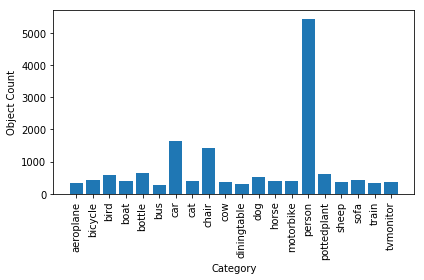

In [4]:
# 5011 images in training set
obj_count = [0] * len(num_to_label)
for idx in range(5011):
    object_labels = train_objects[idx]['labels']
    for object_num in object_labels:
        obj_count[object_num-1] += 1  
obj_count = np.array(obj_count)

plt.bar(list(label_to_num.keys())[:-1], obj_count[:-1])
plt.xticks(rotation=90)
plt.ylabel('Object Count')
plt.xlabel('Category')
plt.tight_layout()
plt.savefig('images/obj_count/training_set_obj_count.png', dpi=300)
plt.show()


## Count occurences of object in each class

In [7]:
def countOccurrences(file_str, train_objects, num_classes=21):
    obj_count = [0] * num_classes
    
    npzfile = np.load(file_str, allow_pickle=True)
    training_data = npzfile['training_data']
    
    obj_count = [0] * len(num_to_label)
    for arr in training_data:
        for idx in arr:
            object_labels = train_objects[idx]['labels']
            for object_num in object_labels:
                obj_count[object_num-1] += 1  
    
    return np.array(obj_count)

all_object_counts = list()

for af in afs:
    file_str = results_path + af + '_' + str(1) + '_test_acc.npy.npz'  
    af_obj_count = countOccurrences(file_str, train_objects)

    all_object_counts.append( (af, np.sum(af_obj_count)) )
    
    plt.bar(list(label_to_num.keys())[:-1], af_obj_count[:-1]) #omit background cls
    plt.xticks(rotation=90)
    plt.ylabel('Object Count')
    plt.xlabel('Category')
    plt.tight_layout()
    plt.savefig('images/obj_count/' + af + '_obj_count.png', dpi=300)
    plt.clf()

all_object_counts.sort(key=lambda tup: tup[1])

for (af, count) in all_object_counts:
    print(af + ' & ' + str(count) + ' \\\ ')
    print('\\hline')
        

MARGIN_SAMPLING & 11179 \\ 
\hline
QBC & 12119 \\ 
\hline
MEAN_STD_WITH_BBOX & 12527 \\ 
\hline
LOCALIZATION_STABILITY & 12534 \\ 
\hline
RANDOM & 12559 \\ 
\hline
VAR_RATIO & 12999 \\ 
\hline
BALD & 13763 \\ 
\hline
ENTROPY & 13806 \\ 
\hline
MEAN_STD & 13812 \\ 
\hline


<Figure size 432x288 with 0 Axes>

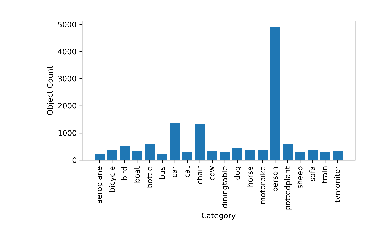

In [8]:
img = mpimg.imread('images/obj_count/' + 'MEAN_STD' + '_obj_count.png')
plt.imshow(img)
plt.axis('off')
plt.show()


## Get difference in images acquired for each class

In [9]:
# baseline comparison
af = 'RANDOM'  
file_str = results_path + af + '_' + str(1) + '_test_acc.npy.npz'  
rand_obj_count = countOccurrences(file_str, train_objects)

# all other comparisons
for af in afs:
    if af == 'RANDOM':
        continue

    file_str = results_path + af + '_' + str(1) + '_test_acc.npy.npz'  
    af_obj_count = countOccurrences(file_str, train_objects)
    

    diff_obj_count = rand_obj_count-af_obj_count
    color_choice = np.where(diff_obj_count > 0, 'b', 'r')
    
    plt.bar(list(label_to_num.keys())[:-1], diff_obj_count[:-1], color=color_choice)
    plt.xticks(rotation=90)
    plt.ylabel('Object Count')
    plt.xlabel('Category')
    plt.tight_layout()
    plt.savefig('images/obj_count/' + af + '_obj_count_diff.png', dpi=300)
    plt.clf()

<Figure size 432x288 with 0 Axes>

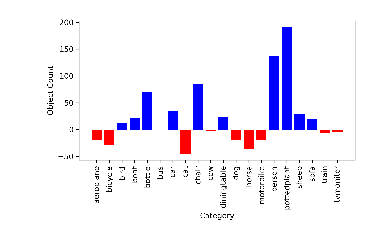

In [10]:
img = mpimg.imread('images/obj_count/' + 'QBC' + '_obj_count_diff.png')
plt.imshow(img)
plt.axis('off')
plt.show()


In [11]:
## Class-wise AP Table generation

In [12]:
# AF x 20 table

print('\\hline')

print_str = 'Acquisition Function '
all_classes = list(label_to_num.keys())[:-1] # get rid of background
for cls in all_classes:
    print_str += cls + ' & '
print_str = print_str[:-2] + ' \\\ '
print(print_str)
print('\\hline')


for af in afs:
    all_ap_list = []
    for i in range(1, 2):
        file_str = results_path + af + '_' + str(i) + '_test_acc.npy.npz'
        
        npzfile = np.load(file_str, allow_pickle=True)
        APs_list = npzfile['APs_list']
        
        final_ap = APs_list[-1]
        final_ap_vals = list(final_ap.values())
        
        all_ap_list.append(final_ap_vals)
    
    ap_mean = np.mean(all_ap_list, axis=0)
    
    print_str = af + ' & '
    
    ap_mean = np.around(ap_mean, decimals=3)
    for i, ap in enumerate(ap_mean):
        print_str = print_str + str(ap) + ' & '
    print_str = print_str[:-2] + ' \\\ '
    print(print_str)
    print('\\hline')




\hline
Acquisition Function aeroplane & bicycle & bird & boat & bottle & bus & car & cat & chair & cow & diningtable & dog & horse & motorbike & person & pottedplant & sheep & sofa & train & tvmonitor  \\ 
\hline
MARGIN_SAMPLING & 0.728 & 0.774 & 0.641 & 0.518 & 0.242 & 0.77 & 0.819 & 0.78 & 0.358 & 0.661 & 0.625 & 0.713 & 0.815 & 0.757 & 0.716 & 0.391 & 0.611 & 0.644 & 0.808 & 0.63  \\ 
\hline
RANDOM & 0.704 & 0.736 & 0.617 & 0.564 & 0.322 & 0.767 & 0.803 & 0.769 & 0.41 & 0.589 & 0.605 & 0.687 & 0.807 & 0.699 & 0.719 & 0.444 & 0.562 & 0.693 & 0.786 & 0.663  \\ 
\hline
LOCALIZATION_STABILITY & 0.718 & 0.78 & 0.639 & 0.56 & 0.348 & 0.747 & 0.798 & 0.775 & 0.45 & 0.677 & 0.648 & 0.749 & 0.809 & 0.771 & 0.72 & 0.376 & 0.633 & 0.684 & 0.785 & 0.674  \\ 
\hline
MEAN_STD & 0.718 & 0.783 & 0.659 & 0.588 & 0.374 & 0.774 & 0.807 & 0.755 & 0.46 & 0.708 & 0.709 & 0.673 & 0.82 & 0.794 & 0.737 & 0.433 & 0.681 & 0.697 & 0.786 & 0.694  \\ 
\hline
ENTROPY & 0.69 & 0.772 & 0.563 & 0.572 & 0.373 & 0.776

In [13]:
# 20 x AF table

all_ap_mean = []

for af in afs:
    all_ap_list = []
    for i in range(1, 2):
        file_str = results_path + af + '_' + str(i) + '_test_acc.npy.npz'
        
        npzfile = np.load(file_str, allow_pickle=True)
        APs_list = npzfile['APs_list']
        
        final_ap = APs_list[-1]
        final_ap_vals = list(final_ap.values())
        
        all_ap_list.append(final_ap_vals)
    
    ap_mean = np.mean(all_ap_list, axis=0)
    
    all_ap_mean.append(ap_mean)
    
all_classes = list(label_to_num.keys())[:-1] # get rid of background
table_top = 'Class & '
for af in afs:
    table_top = table_top + af + ' & '
table_top = table_top[:-2] + ' \\\ '

print(table_top)


for i, cls in enumerate(all_classes):
    print_str = cls + ' & '
    all_scores = []
#     for ap_mean in all_ap_mean:
#         print_str = print_str +  str(np.round(ap_mean[i], decimals=3)) + ' & '
#     print_str = print_str[:-2] + ' \\\ '
#     print(print_str)

    for ap_mean in all_ap_mean:
        all_scores.append(ap_mean[i])
    max_idx = np.argmax(all_scores)
    
    for idx, ap_mean in enumerate(all_ap_mean):
        if idx == max_idx:
            print_str = print_str + '\\textbf{' + \
                        str(np.round(ap_mean[i], decimals=3)) + '} & '
        else:
            print_str = print_str +  str(np.round(ap_mean[i], decimals=3)) + ' & '
    print_str = print_str[:-2] + ' \\\ '
    print(print_str)

Class & MARGIN_SAMPLING & RANDOM & LOCALIZATION_STABILITY & MEAN_STD & ENTROPY & BALD & VAR_RATIO & MEAN_STD_WITH_BBOX & QBC  \\ 
aeroplane & 0.728 & 0.704 & 0.718 & 0.718 & 0.69 & 0.708 & \textbf{0.739} & 0.712 & 0.711  \\ 
bicycle & 0.774 & 0.736 & 0.78 & 0.783 & 0.772 & \textbf{0.798} & 0.772 & 0.793 & 0.787  \\ 
bird & 0.641 & 0.617 & 0.639 & 0.659 & 0.563 & 0.629 & \textbf{0.663} & 0.656 & 0.609  \\ 
boat & 0.518 & 0.564 & 0.56 & \textbf{0.588} & 0.572 & 0.552 & 0.55 & 0.579 & 0.569  \\ 
bottle & 0.242 & 0.322 & 0.348 & \textbf{0.374} & 0.373 & 0.326 & 0.362 & 0.34 & 0.319  \\ 
bus & 0.77 & 0.767 & 0.747 & 0.774 & 0.776 & 0.783 & 0.763 & \textbf{0.783} & 0.76  \\ 
car & \textbf{0.819} & 0.803 & 0.798 & 0.807 & 0.804 & 0.797 & 0.79 & 0.803 & 0.797  \\ 
cat & 0.78 & 0.769 & 0.775 & 0.755 & 0.753 & 0.775 & 0.78 & 0.748 & \textbf{0.8}  \\ 
chair & 0.358 & 0.41 & 0.45 & \textbf{0.46} & 0.45 & 0.452 & 0.451 & 0.438 & 0.444  \\ 
cow & 0.661 & 0.589 & 0.677 & 0.708 & 0.663 & 0.711 & 0.696

## Get number of instances acquired for each class

In [14]:
all_obj_count = []
for af in afs:
    file_str = results_path + af + '_' + str(1) + '_test_acc.npy.npz'  
    obj_count = countOccurrences(file_str, train_objects)
    
    all_obj_count.append(obj_count)
    
top_str = 'Class & '
for af in afs:
    top_str += af + ' & '
top_str = top_str[:-2] + ' \\\ '
print(top_str)
    
category_num = list(num_to_label.keys())[:-1]
for num in category_num:
    cls_wise_count = []
    for obj_count in all_obj_count:
        cls_wise_count.append(obj_count[num-1])
    max_num = np.max(cls_wise_count)
    
    print_str = num_to_label[num] + ' & '
    for count in cls_wise_count:
        if count == max_num:
            print_str += '\\textbf{' + str(count) + '} & '
        else:
            print_str += str(count) + ' & '
            
    print_str = print_str[:-2] + ' \\\ '
    print(print_str)
    


Class & MARGIN_SAMPLING & RANDOM & LOCALIZATION_STABILITY & MEAN_STD & ENTROPY & BALD & VAR_RATIO & MEAN_STD_WITH_BBOX & QBC  \\ 
aeroplane & 301 & 253 & \textbf{316} & 243 & 232 & 249 & 270 & 290 & 273  \\ 
bicycle & 332 & 335 & 278 & 363 & \textbf{381} & 362 & 317 & 332 & 364  \\ 
bird & 479 & 456 & 475 & 516 & 480 & 498 & 519 & \textbf{554} & 444  \\ 
boat & 343 & 317 & \textbf{383} & 342 & 350 & 338 & 351 & 344 & 296  \\ 
bottle & 340 & 519 & 537 & 587 & \textbf{595} & 577 & 570 & 488 & 449  \\ 
bus & 247 & 212 & 228 & 236 & 235 & 237 & 209 & \textbf{249} & 213  \\ 
car & \textbf{1448} & 1321 & 1309 & 1365 & 1367 & 1341 & 1060 & 1337 & 1287  \\ 
cat & 299 & 299 & \textbf{346} & 278 & 232 & 246 & 294 & 311 & 344  \\ 
chair & 664 & 1118 & 1305 & 1324 & 1359 & \textbf{1371} & 1334 & 1126 & 1034  \\ 
cow & 196 & 294 & 246 & 319 & 294 & 316 & 268 & \textbf{321} & 296  \\ 
diningtable & 154 & 247 & 277 & 291 & 292 & \textbf{298} & 292 & 237 & 223  \\ 
dog & 398 & 430 & 413 & 440 & 393 & 

## Finding popular images

In [15]:
popular = [0] * 5011
for af in afs:
    if af == 'RANDOM':
        continue
    
    file_str = results_path + af + '_' + str(1) + '_test_acc.npy.npz' 
    
    npzfile = np.load(file_str, allow_pickle=True)
    training_data = npzfile['training_data']
    
    flat_list = list()
    for indices in training_data:
        flat_list.extend(indices)
    flat_list = flat_list[500:1250] # first 500 imgs always used
    
    for num in flat_list:
        popular[num] += 1
    
ind = np.argsort(popular) # small to big
top_10 = ind[-10:]

# top 10 data
print(top_10)
print([popular[i] for i in top_10])


[2834 1838 1362 2576 1710 3664 3373 4014 2831 1446]
[5, 5, 5, 5, 5, 5, 6, 6, 6, 7]


{'boxes': [[313, 140, 379, 213], [404, 130, 499, 198], [212, 217, 314, 363], [71, 222, 163, 345], [40, 189, 96, 305], [152, 180, 254, 325], [21, 188, 308, 343]], 'labels': [18, 18, 9, 9, 9, 9, 11], 'difficulties': [1, 1, 0, 0, 0, 0, 0]}


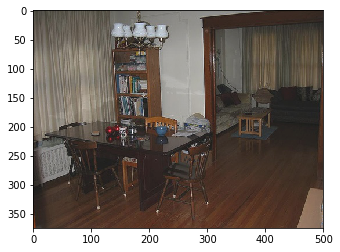

In [16]:
idx = 2834
img = imread(train_images[idx])
plt.imshow(img, alpha=0.9)

print(train_objects[idx])


In [17]:
## Visualize Images Acquired by Various Acquisition Functions

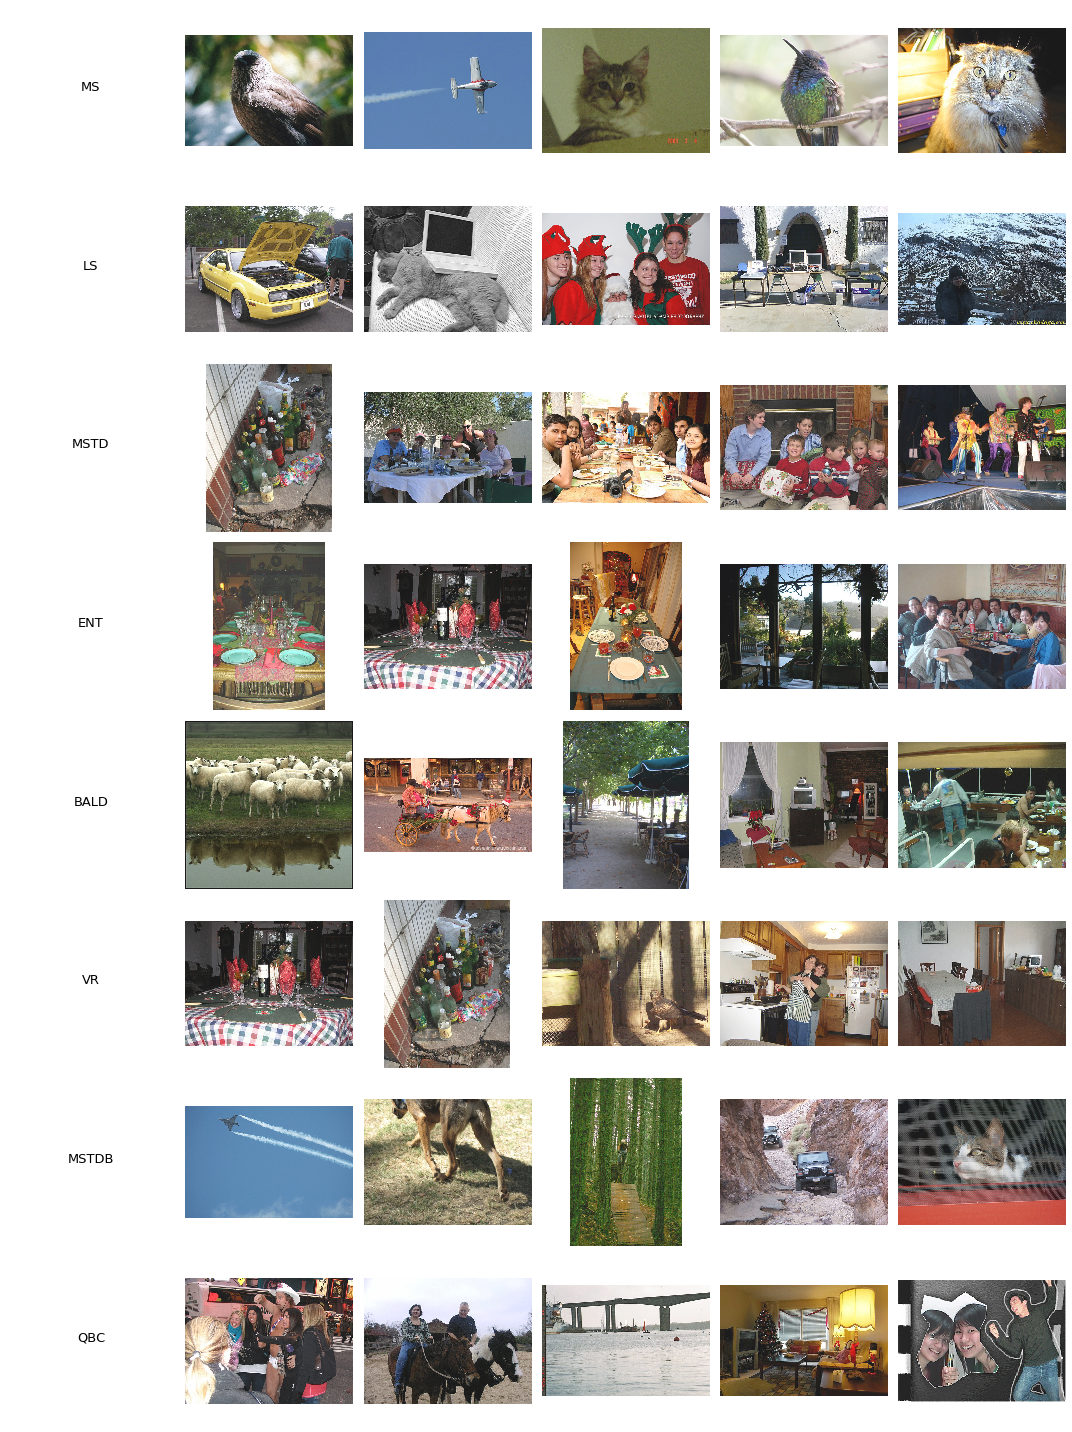

In [18]:
no_rand_afs = afs.copy()
no_rand_afs.remove('RANDOM')
no_rand_afs_simp = afs_simp
no_rand_afs_simp.remove('R')

rows = len(no_rand_afs)
N_best = 5

fig = plt.figure(figsize=(15, 20))

# ax enables access to manipulate each of subplots
ax = []
for row, af in enumerate(no_rand_afs):

    file_str = results_path + af + '_' + str(1) + '_test_acc.npy.npz'  
    npzfile = np.load(file_str, allow_pickle=True)
    training_data = npzfile['training_data']
    
    idx = row*(N_best+1) 
    ax.append( fig.add_subplot(rows, N_best+1, idx+1) )
    ax[-1].text(0.5, 0.5, no_rand_afs_simp[row], 
                fontsize=13, ha='center')
    ax[-1].set_xticklabels([])
    ax[-1].set_yticklabels([])
    ax[-1].axis('off')
    for col in range(N_best):
        idx = row*(N_best+1) + col+1

        img_idx = training_data[-1][col]
        img = imread(train_images[img_idx])
        ax.append( fig.add_subplot(rows, N_best+1, idx+1) )
        ax[-1].set_xticklabels([])
        ax[-1].set_yticklabels([])
        ax[-1].axis('off')
        plt.imshow(img, alpha=0.9)
    
    plt.tight_layout()

    plt.savefig('images/top_N_images.png')



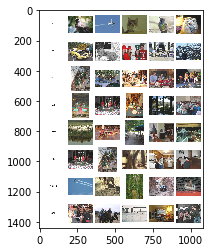

In [4]:
img = imread('images/top_N_images.png')
plt.imshow(img)
